Emotion 'Happiness': 997 images


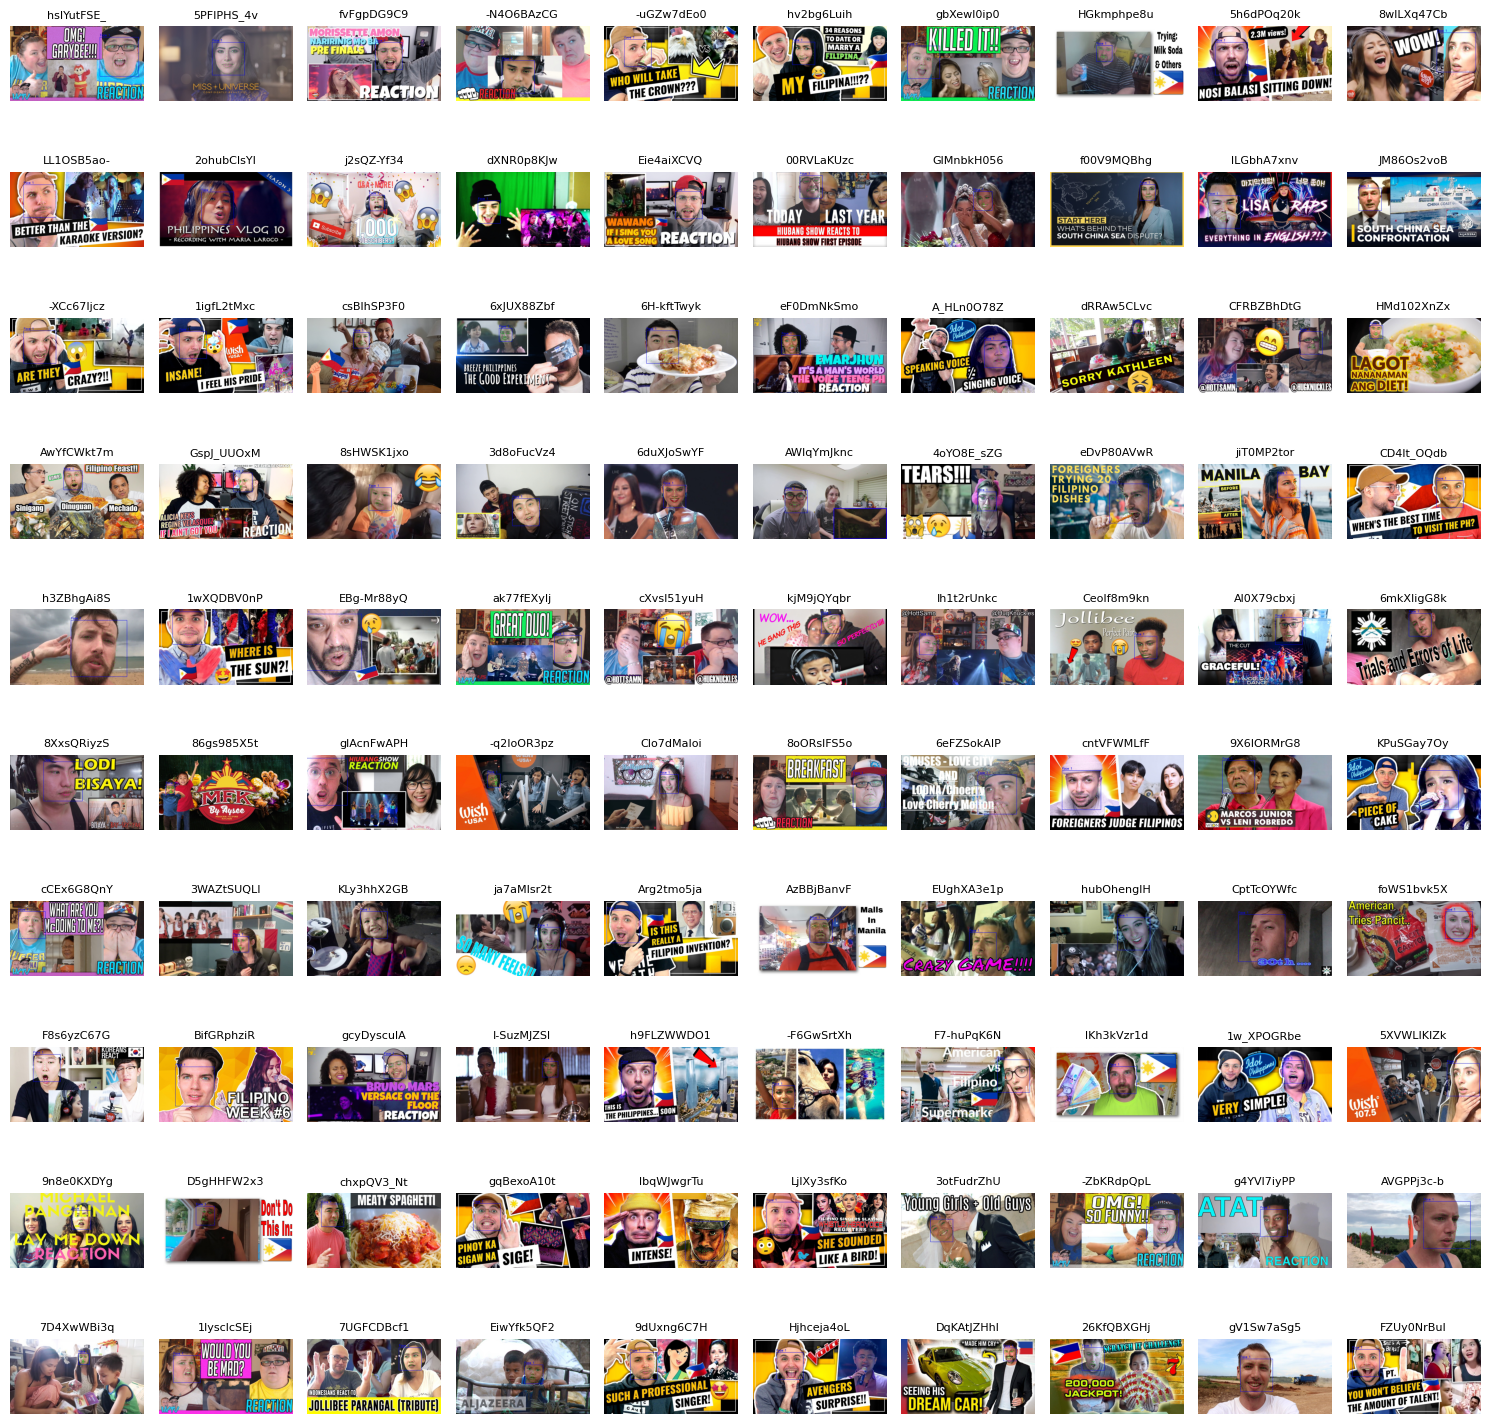

Emotion 'Blinking': 170 images


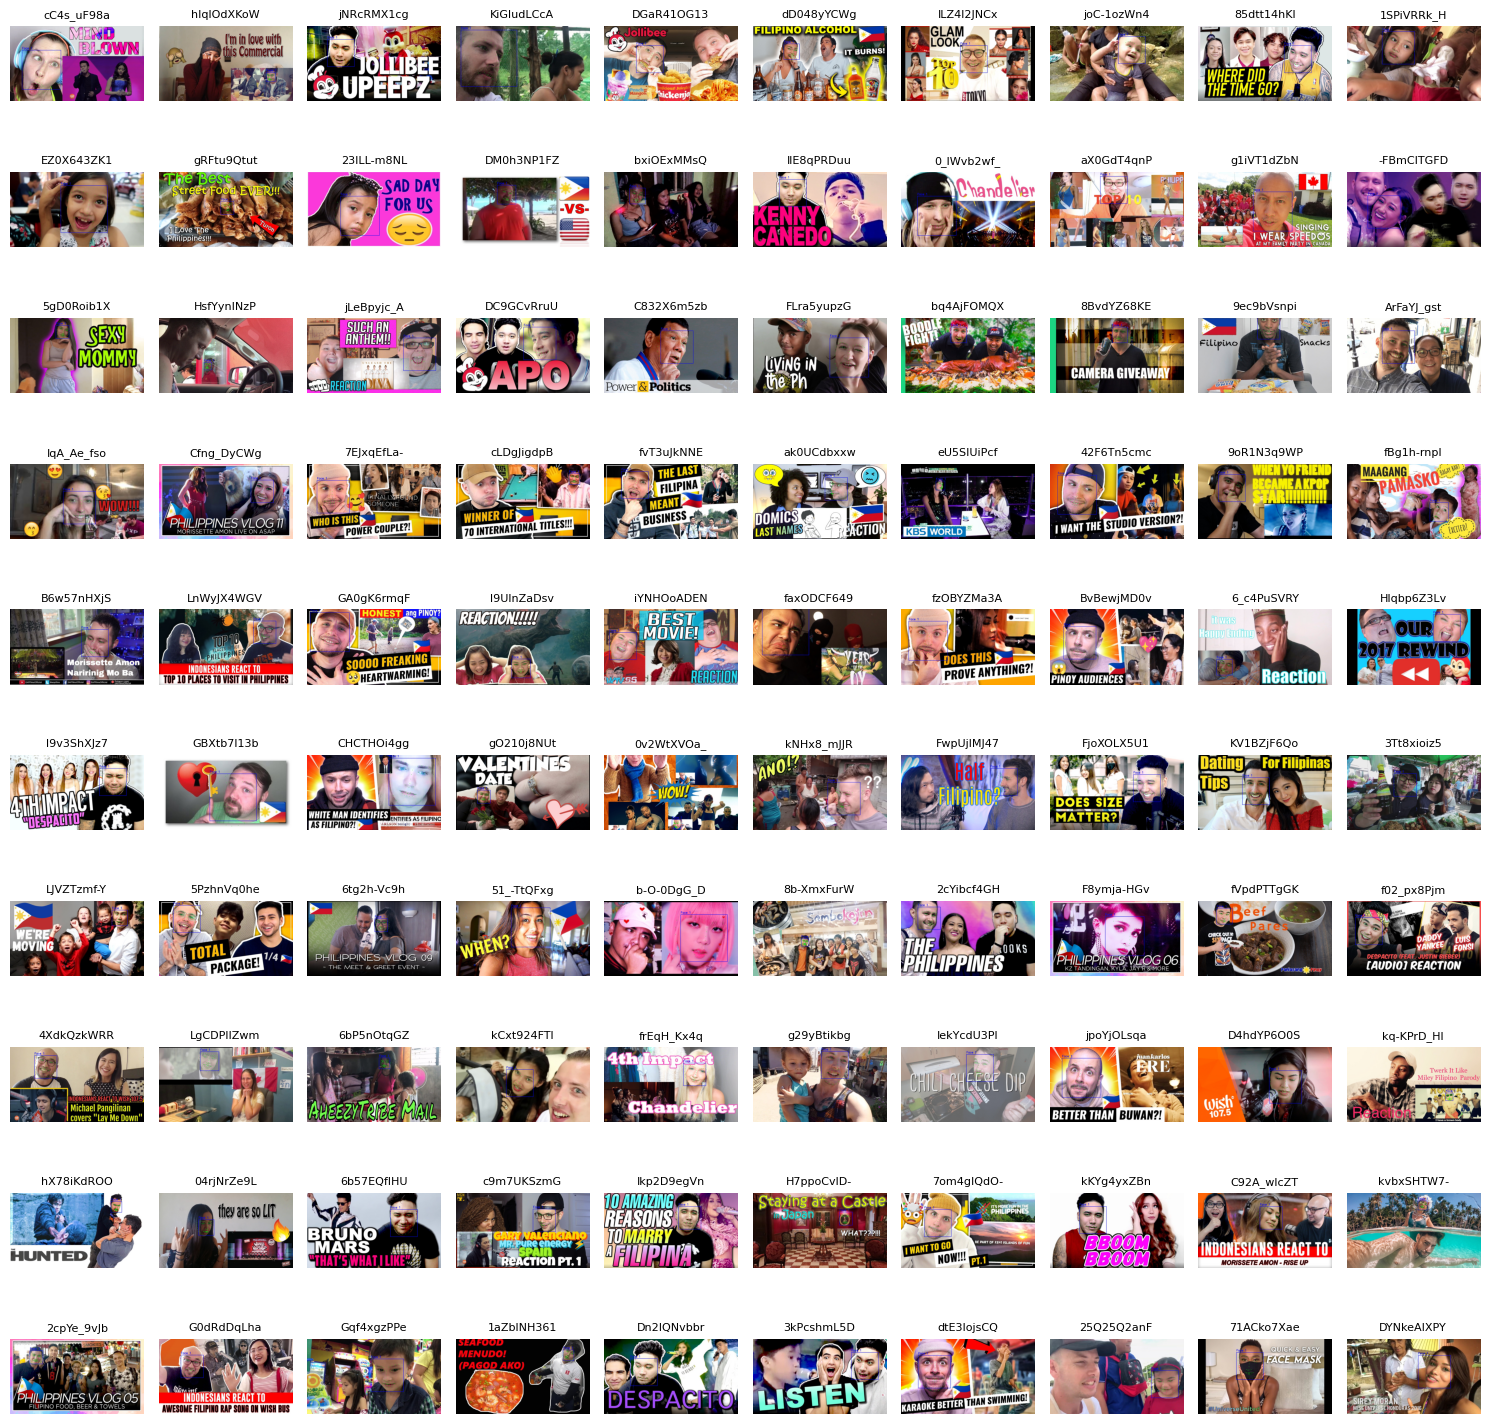

Emotion 'Surprise': 6 images


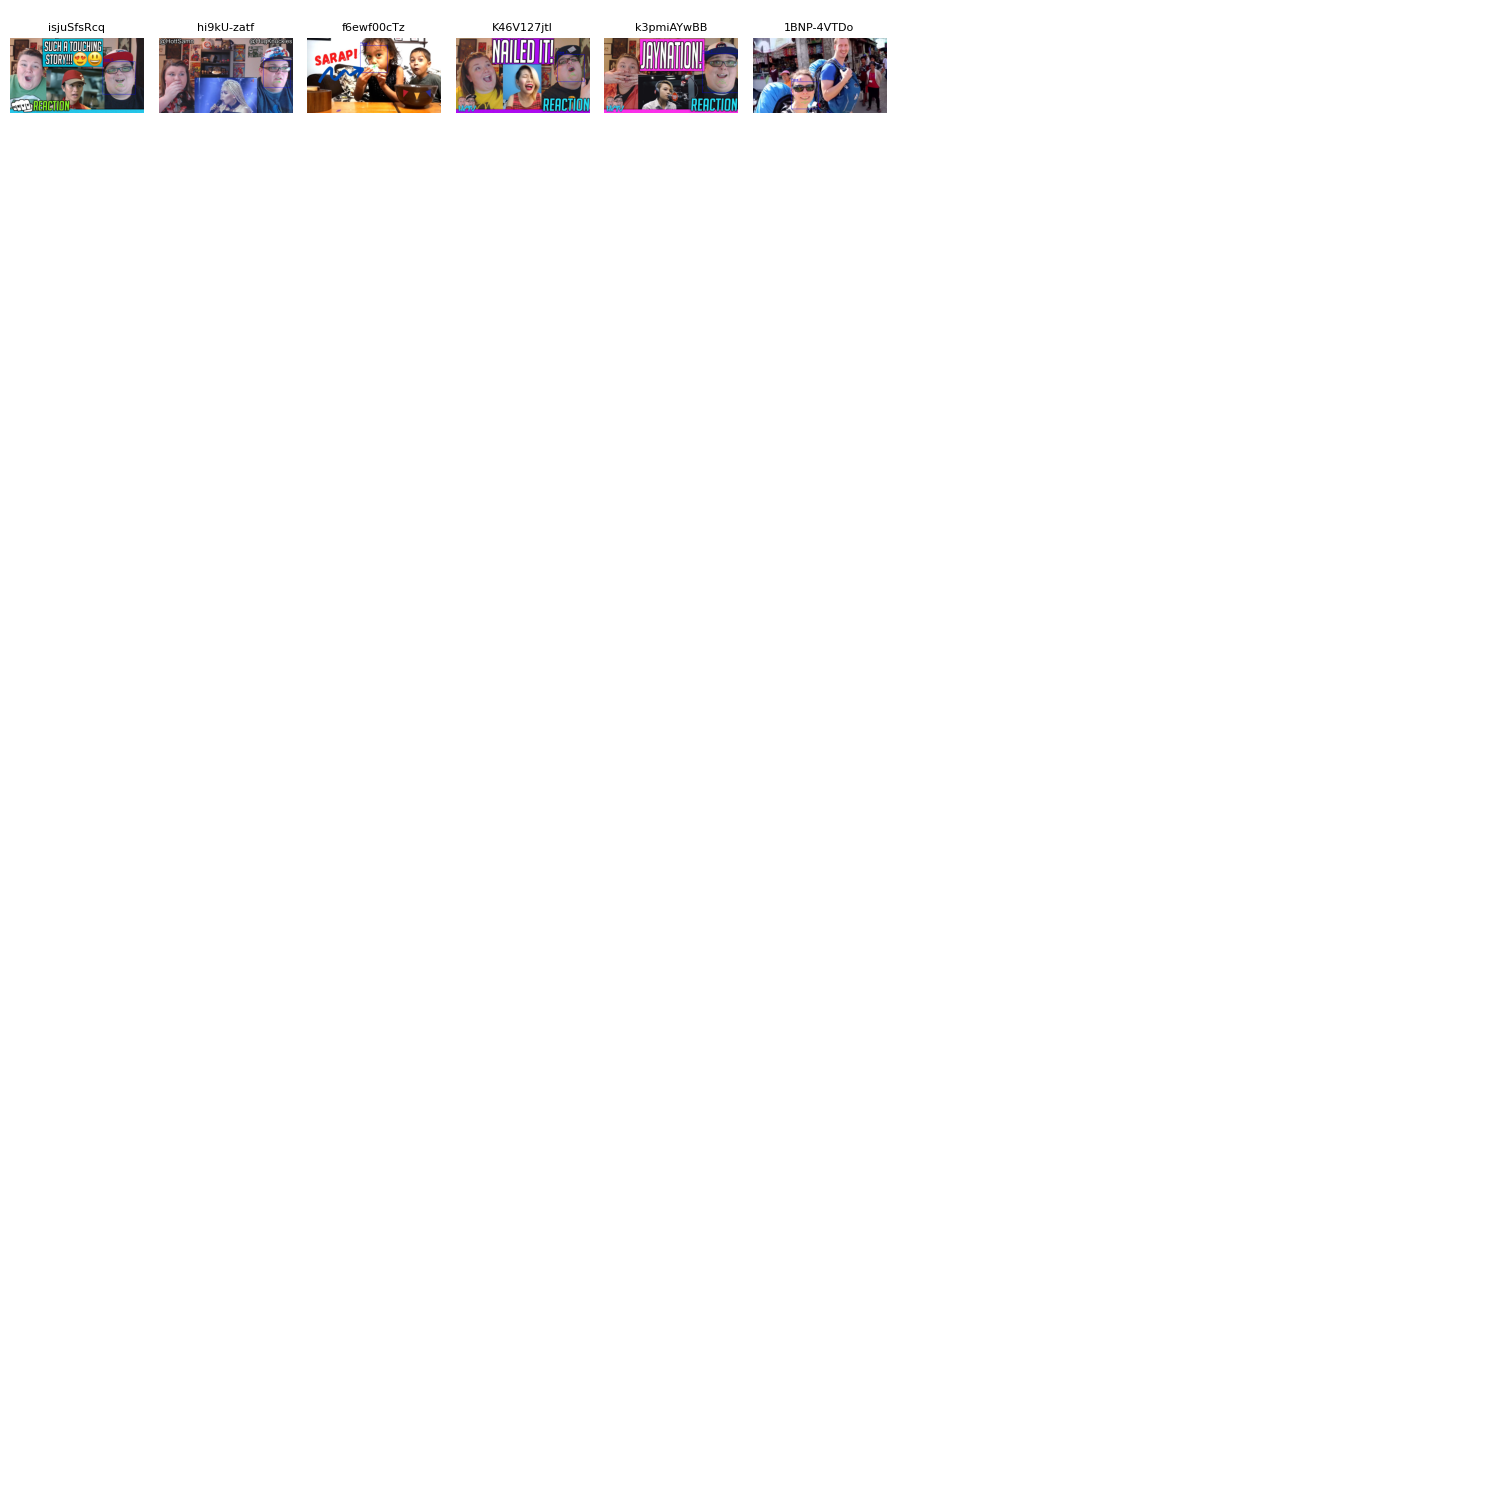

✅ Emotional intensity clustering completed. Thumbnails displayed for each predicted emotion.


In [22]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from itertools import chain
import re


file_path = "face_aus_emotions_with_confidence.csv"
df = pd.read_csv(file_path)

# Function to parse Active AUs column
def parse_aus(au_str):
    try:
        matches = re.findall(r"'(AU\d+)': np\.float64\(([\d.]+)\)", au_str)
        return {au: float(value) for au, value in matches}
    except Exception:
        return {}

# Clean Active AUs column
df["Active AUs"] = df["Active AUs"].apply(parse_aus)

# Remove rows with missing Predicted Emotion
df_cleaned = df.dropna(subset=["Predicted Emotion"]).copy()

# Get all unique AUs for feature extraction
all_aus = sorted(set(chain.from_iterable(df_cleaned["Active AUs"].apply(lambda x: x.keys()))))

# Convert Active AUs into feature vectors
def vectorize_aus(au_dict, all_aus):
    return [au_dict.get(au, 0.0) for au in all_aus]

X = np.array(df_cleaned["Active AUs"].apply(lambda x: vectorize_aus(x, all_aus)).tolist())

# Compute AU Sum (Sum of all AU intensities per row)
df_cleaned["AU Sum"] = X.sum(axis=1)

# Assign random X positions for visualization
df_cleaned["X"] = np.random.rand(len(df_cleaned)) * 100  
df_cleaned["Y"] = df_cleaned["AU Sum"]  # Use AU Sum as Y-axis

# Ensure columns used in hover_data exist
existing_columns = df_cleaned.columns
hover_columns = ["Video ID", "Predicted Emotion", "Active AUs", "Confidence Level"]
valid_hover_data = {col: True for col in hover_columns if col in existing_columns}

# **📊 Interactive Scatter Plot (Colored by Predicted Emotion)**
fig = px.scatter(
    df_cleaned,
    x="X",
    y="Y",
    color="Predicted Emotion",  # Color by emotion
    hover_data=valid_hover_data,
    title="Interactive Clustering of AUs by Predicted Emotion",
    labels={"X": "Random X Position", "Y": "AU Sum (Intensity)"},

)
fig.show()

# **📷 Display Thumbnails for Each Predicted Emotion**
thumbnail_folder = r"C:\Users\alexa\Thesis\processed_thumbnails"  # Adjust to your directory

for emotion in df_cleaned["Predicted Emotion"].unique():
    emotion_images = df_cleaned[df_cleaned["Predicted Emotion"] == emotion]["Image Title"].unique().tolist()
    print(f"Emotion '{emotion}': {len(emotion_images)} images")

    # Create a 10x10 grid (max 100 images per emotion)
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, img_title in enumerate(emotion_images[:100]):
        img_path = os.path.join(thumbnail_folder, img_title)
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(img_title[:10], fontsize=8)  # Shorten title for better fit
        else:
            axes[i].axis("off")
            axes[i].set_title("Not Found", fontsize=8)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

print("✅ Emotional intensity clustering completed. Thumbnails displayed for each predicted emotion.")


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import chain
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load dataset
file_path = "face_aus_emotions_with_confidence.csv"
df = pd.read_csv(file_path)

# Function to parse Active AUs column
def parse_aus(au_str):
    try:
        matches = re.findall(r"'(AU\d+)': np\.float64\(([\d.]+)\)", au_str)
        return {au: float(value) for au, value in matches}
    except Exception:
        return {}

# Clean Active AUs column
df["Active AUs"] = df["Active AUs"].apply(parse_aus)

# Remove rows with missing Predicted Emotion
df_cleaned = df.dropna(subset=["Predicted Emotion"]).copy()

# Get all unique AUs for feature extraction
all_aus = sorted(set(chain.from_iterable(df_cleaned["Active AUs"].apply(lambda x: x.keys()))))

# Convert Active AUs into feature vectors
def vectorize_aus(au_dict, all_aus):
    return [au_dict.get(au, 0.0) for au in all_aus]

X = np.array(df_cleaned["Active AUs"].apply(lambda x: vectorize_aus(x, all_aus)).tolist())

# Compute AU Sum (Sum of all AU intensities per row)
df_cleaned["AU Sum"] = X.sum(axis=1)

# Apply K-Means clustering (5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_cleaned["Cluster"] = kmeans.fit_predict(X)

# Evaluate Clusters
silhouette_avg = silhouette_score(X, df_cleaned["Cluster"])
davies_bouldin_avg = davies_bouldin_score(X, df_cleaned["Cluster"])

# Display results
print(f"🔹 Silhouette Score: {silhouette_avg:.4f} (Higher is better)")
print(f"🔹 Davies-Bouldin Index: {davies_bouldin_avg:.4f} (Lower is better)")

# Optional: Show Cluster Sizes
print("\n📊 Cluster Sizes:")
print(df_cleaned["Cluster"].value_counts())



🔹 Silhouette Score: 0.9347 (Higher is better)
🔹 Davies-Bouldin Index: 0.4732 (Lower is better)

📊 Cluster Sizes:
Cluster
0    2237
1      10
2       4
4       3
3       2
Name: count, dtype: int64
